# Gaussian Process Factor Analysis Regression

## Introduction

Gaussian Process Factor Analysis (GPFA), introduced in [this paper](https://papers.nips.cc/paper/2008/file/ad972f10e0800b49d76fed33a21f6698-Paper.pdf) learns underlying latent trajectories for the outputs while smoothing the data. A more [recent paper](https://papers.nips.cc/paper/2020/file/6d79e030371e47e6231337805a7a2685-Paper.pdf) suggests scalable implementations for GPFA (in the [supplement](https://papers.nips.cc/paper/2020/file/6d79e030371e47e6231337805a7a2685-Supplemental.pdf) ) as well as extending GPFA with kernels for dynamical systems. The implementation in this notebook is developed with a future GPFA for Dynamical Systems (GPFADS) extension in mind. 

GPFA(DS) are useful when you want to simultaneous smooth and reduce the dimensionality of neural data. 

Given test_xpoints $t$, $M$ latent variables $x$ with underlying kernels $k_1, ...k_M$, and observations (neural data) $y$ from $N$ neurons, the observations in GPFA are are assumed to arise as follows:
- The latents variables are independent of eachother:
$$ k(x_i(t), x_j(t')) = \delta_{ij} k_i(t,t')
$$

- We write the above in a vector of latents as:
$$k[\mathbf{x}(t), \mathbf{x}(t')] = \sum_{i=1}^{M}k_i(t,t')\otimes (\mathbf{e}_i \mathbf{e}_i^T)
$$

- We combine the latents into observations as follows:
$$k[\mathbf{y}(t), \mathbf{y}(t')] = (C) k( \mathbf{x}(t) , \mathbf{x}(t'))(C^T)
$$

where $k_i$ is a standard kernel (e.g. RBF) that operates on the inputs.
$\delta_{ij}$ is the Kronecker delta, $\mathbf{e}_i$ is a unit vector of length $M$ with nonzero element at index $i$, $\otimes$ is the Kronecker product, and $C\in NxM$ is the mixing matrix, indicating how latents are combined into observations.


GPFA is mathematically identical to [LMC/LCM](https://docs.gpytorch.ai/en/stable/variational.html#lmcvariationalstrategy) which arose from the geostatistics literature. Both LCM/LMC and GPFA construct a multi-output kernel as the covariance of a linear combination of multiple latent Gaussian processes. However, in GPFA, we are interested in recovering the posterior over these latents processes (not possible with GPyTorch's LMC model), hence the extension of LMC proposed here. Due to the gridded structure of neural data, and the relatively sparse sampling of data per lengthscale, GPFA does not need to rely on inducing points and can instead be modeled using exact / iterative GPs.

In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data
In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1], our data will be drawn from the generative model assumed in GPFA.

In [2]:
def generate_GPFA_Data(seed=0, n_timepoints=100, n_latents=2, num_obs=50, length_scales = [.01,10],start_time=-5, end_time = 5,zero_mean = True):
    torch.manual_seed(seed)
    np.random.seed(seed)
    timepoints = torch.linspace(start_time, end_time, n_timepoints)
    tau = torch.tensor(length_scales)
    C = torch.tensor(np.random.normal(scale=1./np.sqrt(n_latents),size=(num_obs,n_latents))).float()
    if zero_mean:
        d = torch.zeros(size=(num_obs,1)).float()
    else:
        d = torch.tensor(np.random.uniform(size=(num_obs,1))).float()
    R = torch.tensor(np.diag(np.random.uniform(size=(num_obs,), low=.1))).float()
    kernels = [gpytorch.kernels.RBFKernel() for t in tau]
    for t in range(len(tau)):
        kernels[t].lengthscale = tau[t]

    xs = torch.stack([
        gpytorch.distributions.MultivariateNormal(
            torch.zeros(n_timepoints), 
            k(timepoints,timepoints) 
        ).sample()
        for k in kernels])

    ys = gpytorch.distributions.MultivariateNormal((C@xs + d).T, R).sample()
    
    xs = xs.T.contiguous()
    
    return timepoints, tau, C, d, R, kernels, xs, ys

In [3]:
n_latents=2
num_obs=20
n_timepoints = 100
length_scales = [.1,.2]
start_time = 0
end_time = 1
train_x, tau, C, d, R, kernels, xs, train_y = generate_GPFA_Data(
    seed=10, n_timepoints=n_timepoints, n_latents=n_latents, num_obs=num_obs, 
    length_scales = length_scales,start_time = start_time, end_time = end_time, zero_mean =True)

/scratch/jts58/devenv/lib/python3.7/site-packages/gpytorch-1.4.0-py3.7.egg/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


## Define a multitask model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Exact_GPs/Simple_GP_Regression.ipynb).
The differences:

1. We're going to wrap ConstantMean with a `MultitaskMean`. This makes sure we have a mean function for each output dimension.
2. Rather than just using a RBFKernel, we're using that in conjunction with a `GPFAKernel`. This gives us the covariance function described in the introduction.
3. We're using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood`. This allows us to deal with the predictions/outputs in a nice way. For example, when we call MultitaskMultivariateNormal.mean, we get a `T x N` matrix back (where `T` is the number of test_xpoints).


You may also notice that we don't use a ScaleKernel, since the GPFAKernel will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [4]:
from gpytorch.kernels import GPFAKernel
from gpytorch.lazy import DiagLazyTensor, KroneckerProductLazyTensor, KroneckerProductDiagLazyTensor

class GPFAModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, latent_covar_modules,  num_latents, num_obs):
        super(GPFAModel, self).__init__(train_x, train_y, likelihood)
        
        self.num_latents = num_latents
        self.num_obs = num_obs
        
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_obs
        )
        self.covar_module = GPFAKernel(latent_covar_modules,num_latents, num_obs)
        
    def forward(self, x):
        return gpytorch.distributions.MultitaskMultivariateNormal(self.mean_module(x), self.covar_module(x))
    
    def latent_posterior(self, x):
        r'''
        See equations 4 and 5 in `Non-reversible Gaussian processes for
        identifying latent dynamical structure in neural data`_

        .. _Non-reversible Gaussian processes for identifying latent dynamical structure in neural data:
        https://papers.nips.cc/paper/2020/file/6d79e030371e47e6231337805a7a2685-Paper.pdf
        '''
        I_t = DiagLazyTensor(torch.ones(len(x)))
        combined_noise = (self.likelihood.task_noises if self.likelihood.has_task_noise
                          else torch.zeros(self.likelihood.num_tasks)) + (
                              self.likelihood.noise
                              if self.likelihood.has_global_noise else 0)
        Kyy = self.covar_module(x) + KroneckerProductDiagLazyTensor(
            I_t, DiagLazyTensor(combined_noise))

        Kxx = self.covar_module.latent_covar_module(x)

        C_Kron_I = KroneckerProductLazyTensor(I_t, self.covar_module.C)

        mean_rhs = (train_y - self.mean_module(x)).view(
            *(train_y.numel(),
              ))  # vertically stacks after doing the subtraction

        latent_mean = Kxx @ C_Kron_I.t() @ Kyy.inv_matmul(mean_rhs)
        latent_mean = latent_mean.view(*(len(x),
                                         int(latent_mean.shape[0] / len(x))))

        cov_rhs = C_Kron_I @ Kxx
        latent_cov = Kxx - Kxx @ C_Kron_I.t() @ Kyy.inv_matmul(
            cov_rhs.evaluate())
        return gpytorch.distributions.MultitaskMultivariateNormal(
            latent_mean, latent_cov)


In [5]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_obs)
kernels = [gpytorch.kernels.RBFKernel() for t in range(n_latents)]
model=GPFAModel(train_x,train_y, likelihood,  kernels, n_latents, num_obs)

### Train the model hyperparameters

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %2d/%d - Loss: %.3f, Lengthscale 1: %.3f, Lengthscale 2: %.3f' 
          % (i + 1, training_iterations, loss.item(), kernels[0].lengthscale.float(), kernels[1].lengthscale.float()))
    optimizer.step()

Iter  1/50 - Loss: 148.949, Lengthscale 1: 0.693, Lengthscale 2: 0.693
Iter  2/50 - Loss: 147.468, Lengthscale 1: 0.744, Lengthscale 2: 0.744
Iter  3/50 - Loss: 145.879, Lengthscale 1: 0.798, Lengthscale 2: 0.708
Iter  4/50 - Loss: 144.214, Lengthscale 1: 0.853, Lengthscale 2: 0.669
Iter  5/50 - Loss: 142.446, Lengthscale 1: 0.910, Lengthscale 2: 0.629
Iter  6/50 - Loss: 140.551, Lengthscale 1: 0.935, Lengthscale 2: 0.590
Iter  7/50 - Loss: 138.550, Lengthscale 1: 0.958, Lengthscale 2: 0.552
Iter  8/50 - Loss: 136.482, Lengthscale 1: 0.970, Lengthscale 2: 0.515
Iter  9/50 - Loss: 134.373, Lengthscale 1: 0.971, Lengthscale 2: 0.479
Iter 10/50 - Loss: 132.267, Lengthscale 1: 0.952, Lengthscale 2: 0.444
Iter 11/50 - Loss: 130.211, Lengthscale 1: 0.923, Lengthscale 2: 0.409
Iter 12/50 - Loss: 128.170, Lengthscale 1: 0.886, Lengthscale 2: 0.377
Iter 13/50 - Loss: 126.123, Lengthscale 1: 0.844, Lengthscale 2: 0.346
Iter 14/50 - Loss: 124.095, Lengthscale 1: 0.798, Lengthscale 2: 0.317
Iter 1

### Make predictions with the model

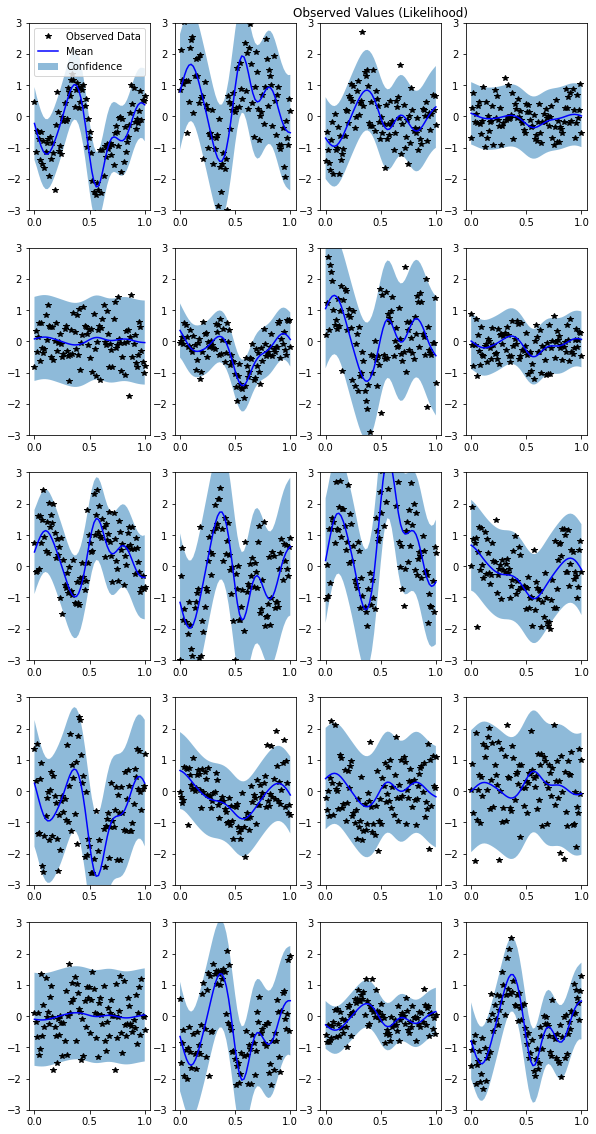

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axes = plt.subplots(5, 4, figsize=(10, 20))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# This plots predictions for all observed neurons
for i, ax in enumerate(axes.flatten()):
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, i].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, i].numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.numpy(), lower[:, i].numpy(), upper[:, i].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    if i==0:
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
    if i==2:
        ax.set_title('Observed Values (Likelihood)')


None

### Find the Latents

These latents will only 'match' up to an ordering and negation of the true latents. 

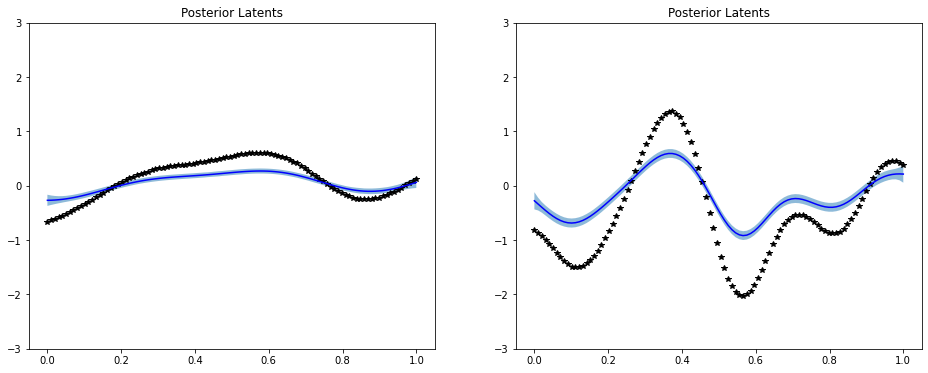

In [8]:
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots( 1, n_latents, figsize=(16, 6))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    predictions = model.latent_posterior(test_x)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

for i in range(n_latents):
    ax = axs[i]
    # Plot true hidden latents as black stars
    ax.plot(train_x.cpu().detach().numpy(), (-1 if i==0 else 1)*xs[:, (i-1)%2].cpu().detach().numpy(), 'k*', label= "Hidden Latents")
    # Predictive mean as blue line
    ax.plot(test_x.cpu().numpy(), mean[:, i].cpu().detach().numpy(), 'b', label='Posterior Latent Mean')
    # Shade in confidence 
    ax.fill_between(test_x.cpu().numpy(), lower[:, i].cpu().numpy(), upper[:, i].cpu().numpy(), alpha=.5, label="Posterior Latent Confidence Region")
    ax.set_ylim([-3, 3])
#
    ax.set_title('Posterior Latents')

#### Orthonormalized Latents

Here we orthonormalize latents as described in [this paper](http://papers.nips.cc/paper/3494-gaussian-process-factor-analysis-for-low-dimensional-single-trial-analysis-of-neural-population-activity.pdf) (last paragraph of section 2), matching up to negation.

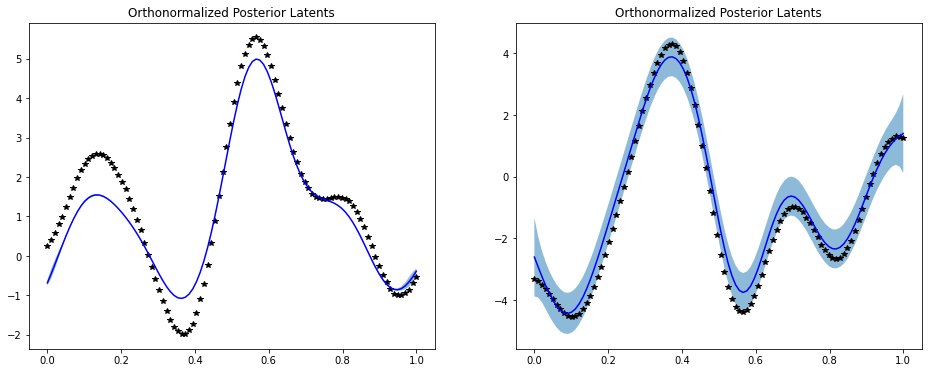

In [9]:
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots( 1, n_latents, figsize=(16, 6))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    #predictions, U_C_pred = model.latent_posterior(test_x)
    predictions = model.latent_posterior(test_x)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
    U_C_pred, S, V = torch.svd(model.covar_module.C, some=False)
    mean = (S*V.T@mean.T).T
    upper = (S*V.T@upper.T).T
    lower = (S*V.T@lower.T).T
    
    U_C, S, V = torch.svd(C, some=False)
    xs_ortho = (S*V.T@xs.T).T
    

for i in range(n_latents):
    ax = axs[i]
    # Plot true hidden latents as black stars
    ax.plot(train_x.cpu().detach().numpy(), xs_ortho[:, i].cpu().detach().numpy(), 'k*', label= "Hidden Latents")
    # Predictive mean as blue line
    ax.plot(test_x.cpu().numpy(), mean[:, i].cpu().detach().numpy(), 'b', label='Posterior Latent Mean')
    # Shade in confidence 
    ax.fill_between(test_x.cpu().numpy(), lower[:, i].cpu().numpy(), upper[:, i].cpu().numpy(), alpha=.5, label="Posterior Latent Confidence Region")
   # ax.set_ylim([-3, 3])
#
    ax.set_title('Orthonormalized Posterior Latents')